Importing the necessary libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result


# Data Exploration

In [10]:
# We are reading the dataset into pandas and we want to look at the first five rows with the head fuction
data_df=pd.read_csv('creditcard.csv')
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
# the mathematical description of the dataset
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
# Finding missing values in the dataset
total_missing = data_df.isnull().sum().sort_values(ascending = False)
percentage = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total_missing, percentage], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data Analysis

In [13]:
# plotting the target features to check the numbers of fraudulent and non fraudulent transactions
class_values = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': class_values.index,'values': class_values.values})

tra = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [tra]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')
plt.show;

The graph above shows that only 492 transactions out of total 284,807 are fraudulent, it shows how highly imbalanced the class target are.

In [14]:
# Density distribution across the class
class_zero = data_df.loc[data_df['Class'] == 0]["Time"]
class_one = data_df.loc[data_df['Class'] == 1]["Time"]

histogram_data = [class_zero, class_one]
labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(histogram_data, labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')
plt.show();

In [15]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tempt = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tempt)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


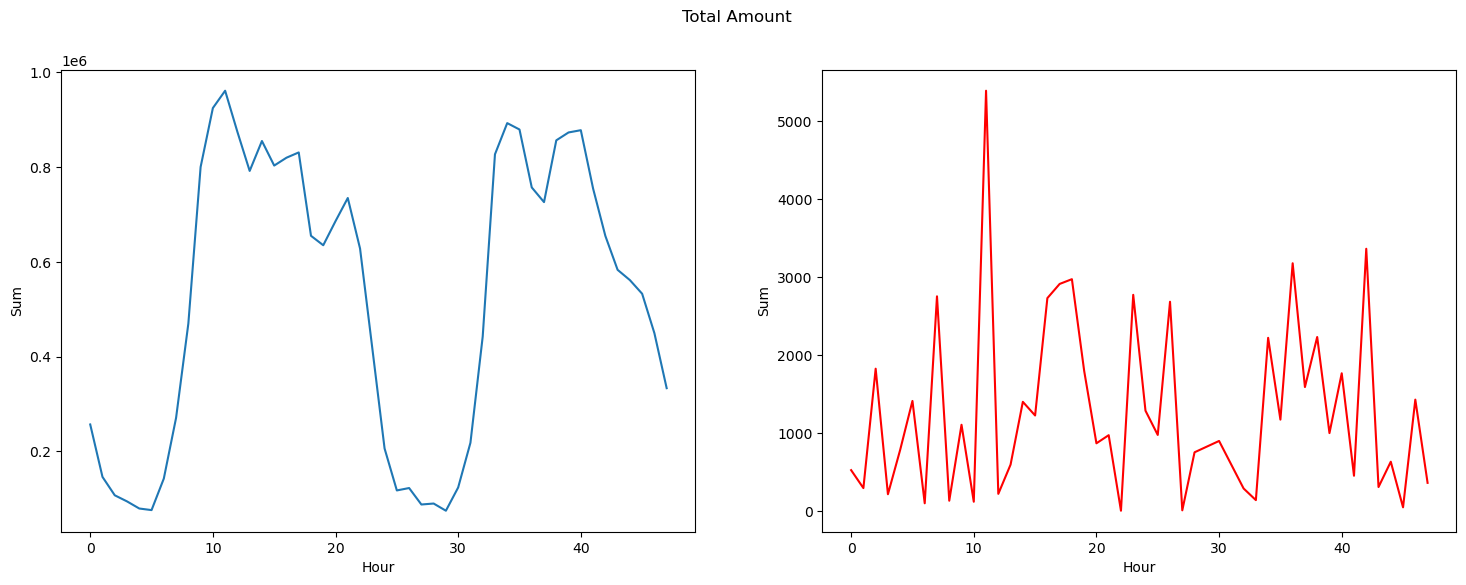

In [16]:
# Plot showing the total amount of transactions across all classes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

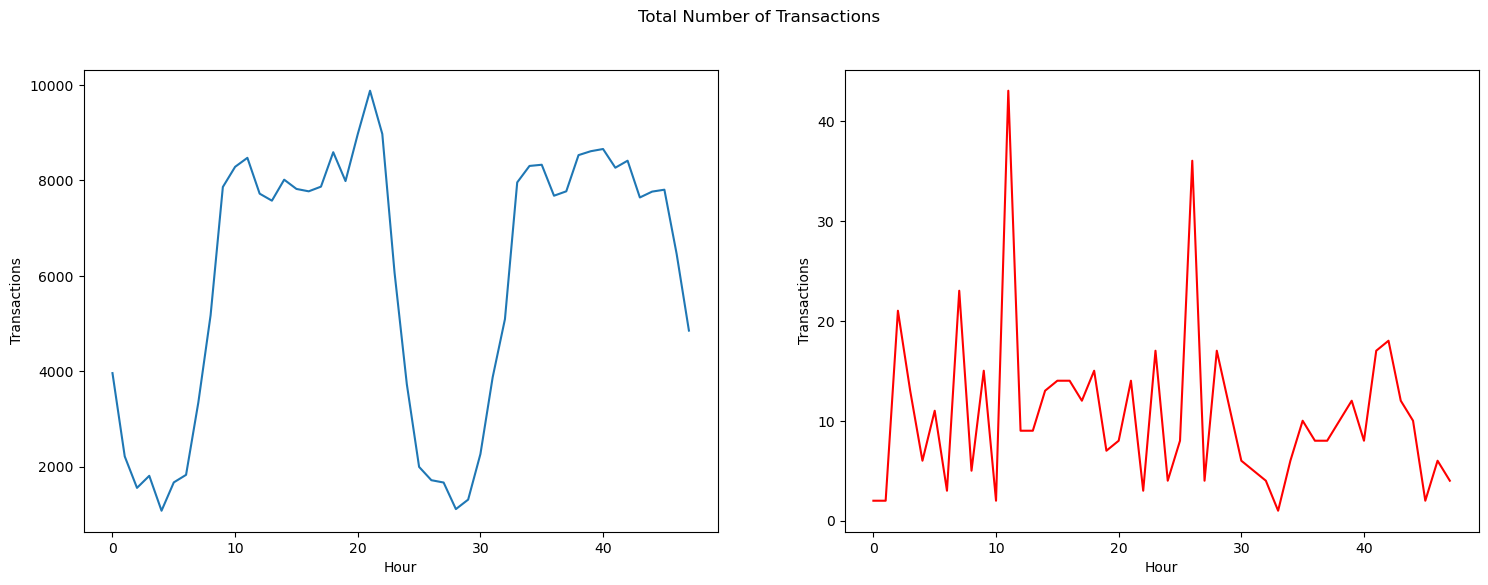

In [17]:
# Plot showing total number of transactions per hour
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

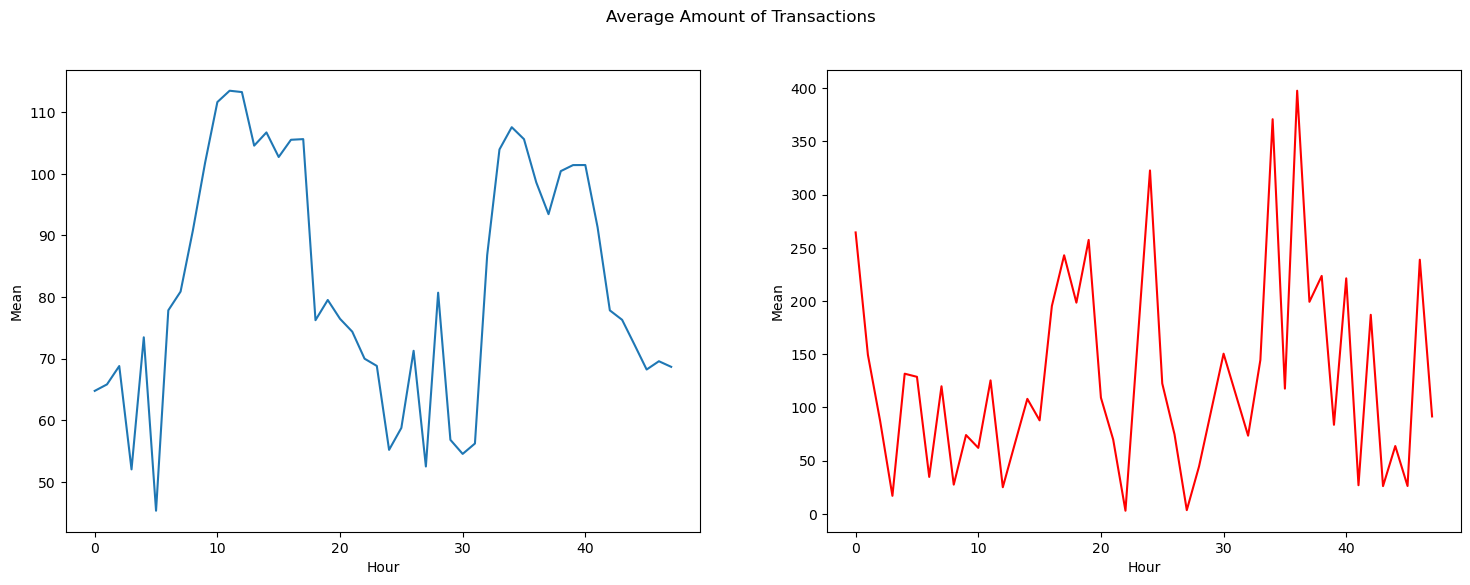

In [18]:
# plotting the average number of transactions per hour
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

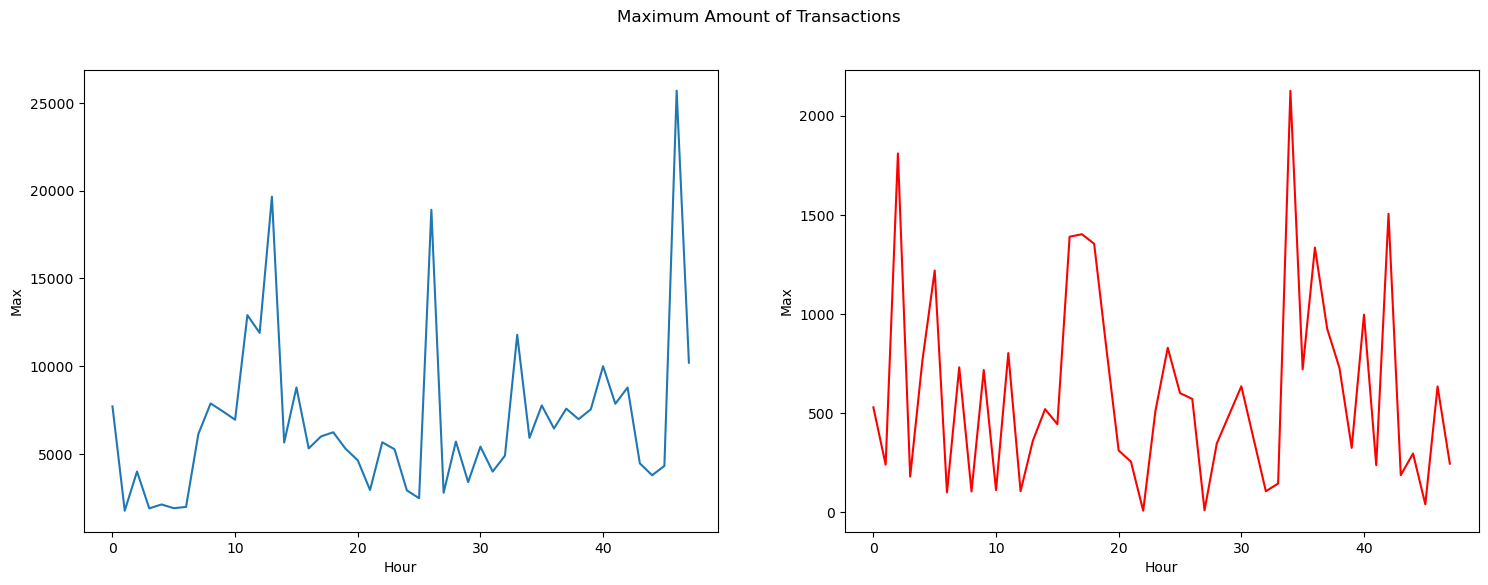

In [19]:
# plotting the maximum number of transactions per hour
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

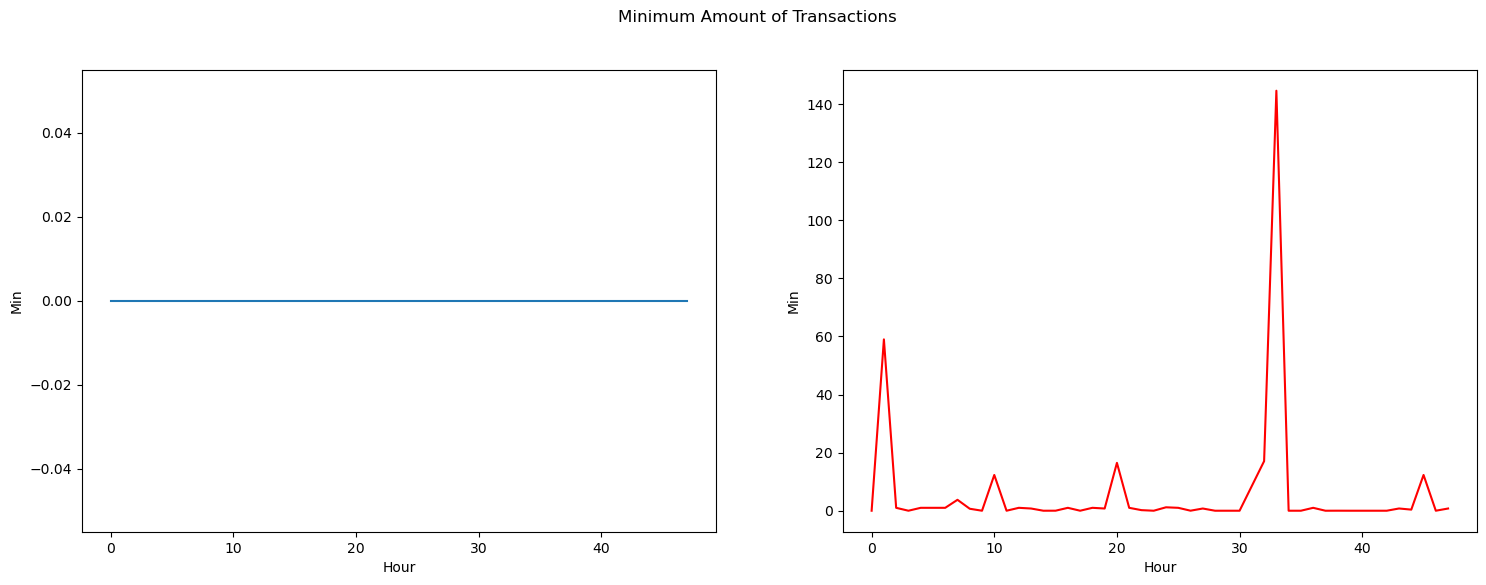

In [20]:
# plotting the minimum number of transactions per hour
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

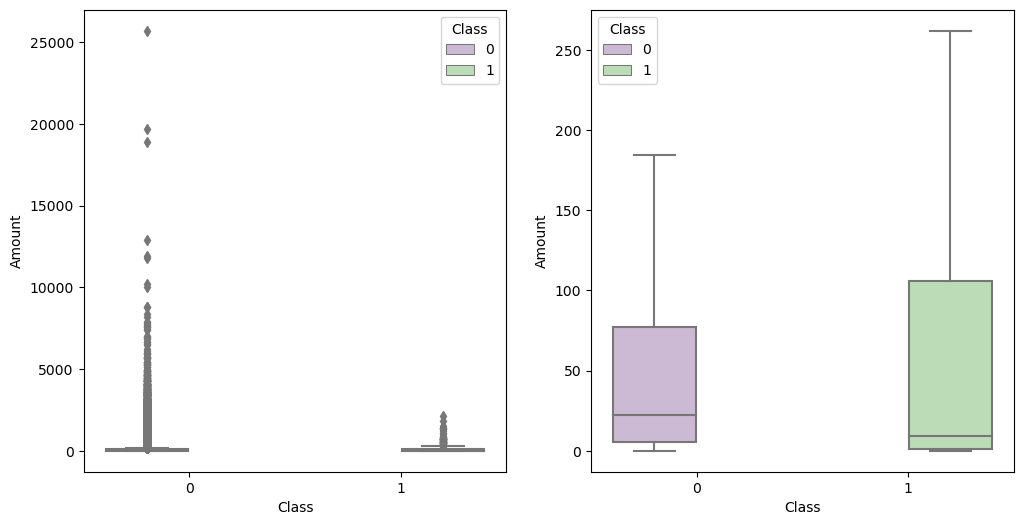

In [21]:
# Box plot showing class distributions per amount
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

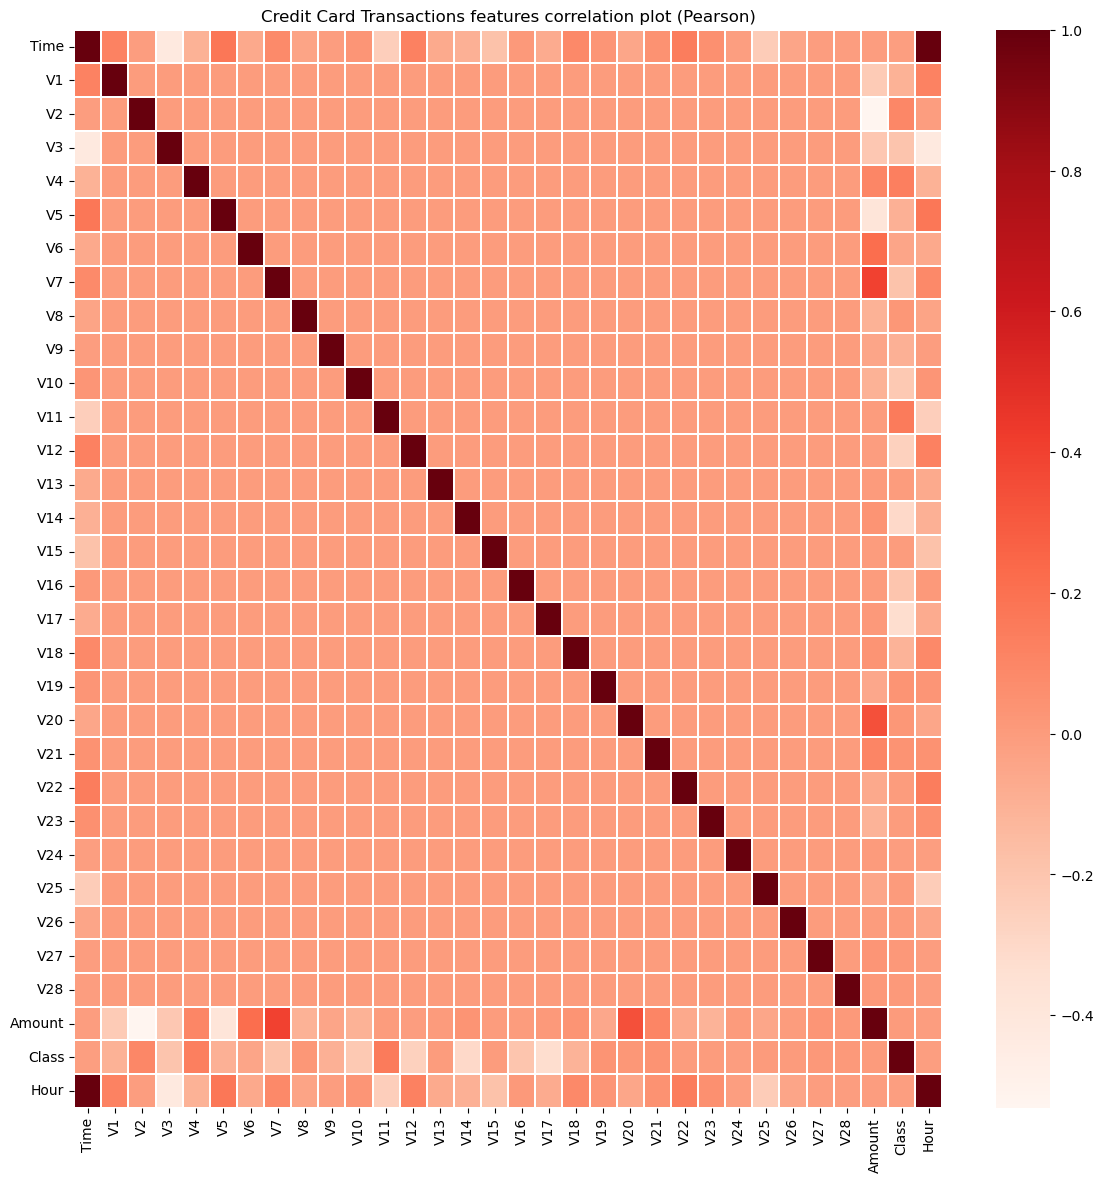

In [22]:
# Correlation plot against all features
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5)

Defining inputs and targets

In [23]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

# Split data in train, test and validation set

In [24]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [25]:
# length of the training dataset
len(train_df.columns)

32

In [26]:
# Length of the testing dataset
len(test_df.columns)

32

In [27]:
# length of the validation dataset
len(valid_df.columns)

32

The models below are built with the imbalanced nature of the dataset

# RandomForest Classifier

In [28]:
# Training the dataset using random forest, note that the dataset is imbalance
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [29]:
# Fitting of the datset on the training and testing dataset
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [30]:
#Prediction
preds = clf.predict(valid_df[predictors])

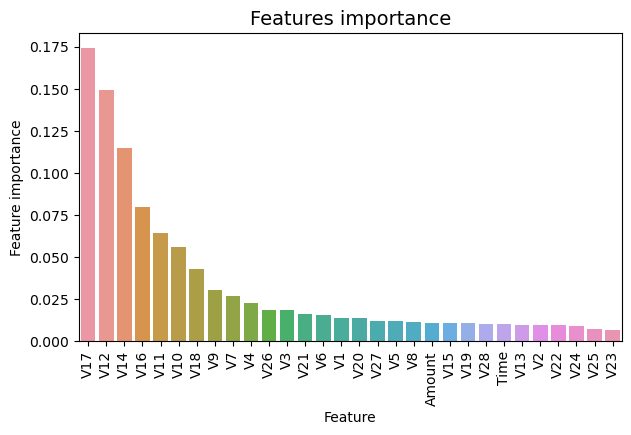

In [31]:
# Plotting the feature importance of all features under random forest
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   
#The most important features are V17, V12, V14, V10, V11, V16.

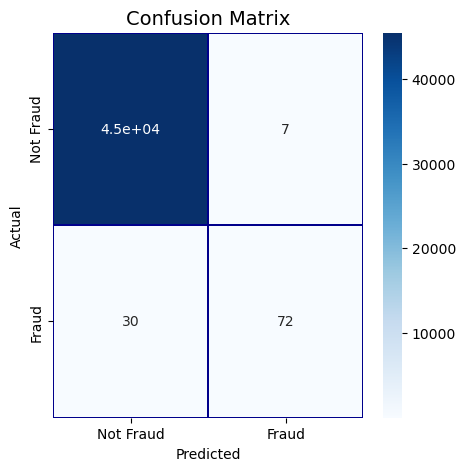

In [32]:
# Confusion matrix
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [33]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

# AdaBoost Classifier

In [34]:
# Training the dataset using Adaboost classifier, note that the dataset is imbalance
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [35]:
# Fitting of the datset on the training and testing dataset
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [36]:
# Prediction
preds = clf.predict(valid_df[predictors])

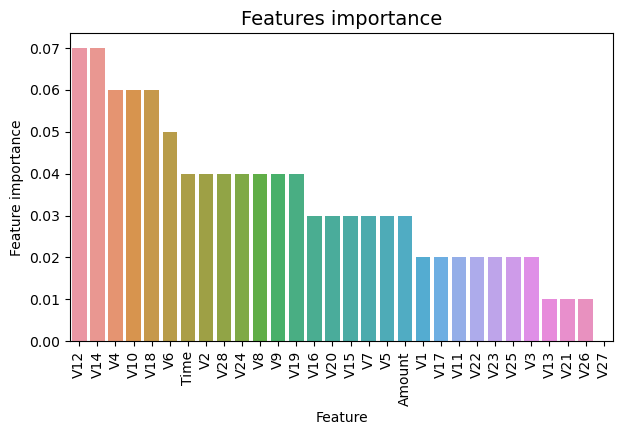

In [37]:
# Plotting the feature importance of all features under Adaboost classifier
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

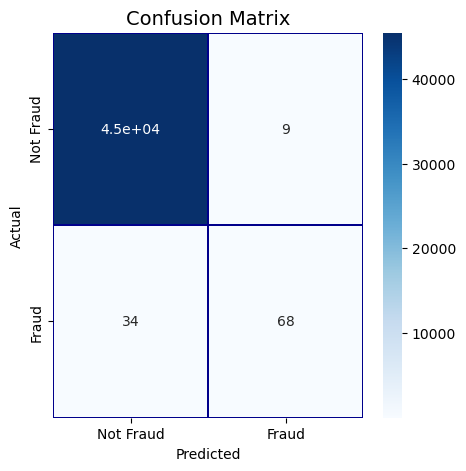

In [38]:
# Confusion matrix
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [39]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

# CatBoost Classifier

In [40]:
# Training the dataset using Catboost classifier, note that the dataset is imbalance
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [41]:
# Fitting of the datset on the training and testing dataset
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 1.64s	remaining: 13m 37s
50:	total: 1m 3s	remaining: 9m 21s
100:	total: 1m 57s	remaining: 7m 42s
150:	total: 2m 46s	remaining: 6m 24s
200:	total: 3m 29s	remaining: 5m 12s
250:	total: 4m 22s	remaining: 4m 20s
300:	total: 5m 15s	remaining: 3m 28s
350:	total: 6m 5s	remaining: 2m 35s
400:	total: 6m 59s	remaining: 1m 43s
450:	total: 7m 46s	remaining: 50.7s
499:	total: 8m 37s	remaining: 0us


In [42]:
# Prediction
preds = clf.predict(valid_df[predictors])

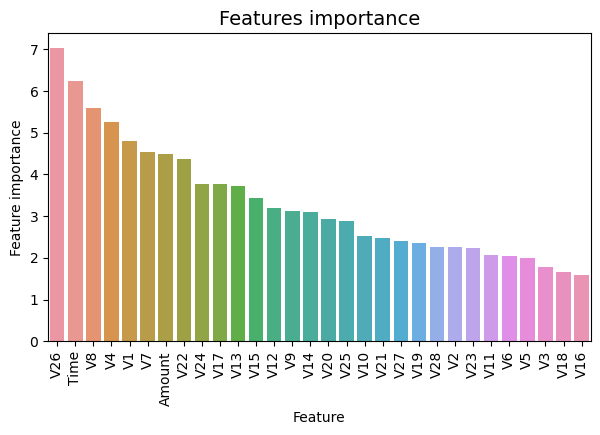

In [43]:
# Plotting the feature importance of all features under Catboost classifier
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   
preds = clf.predict(valid_df[predictors])

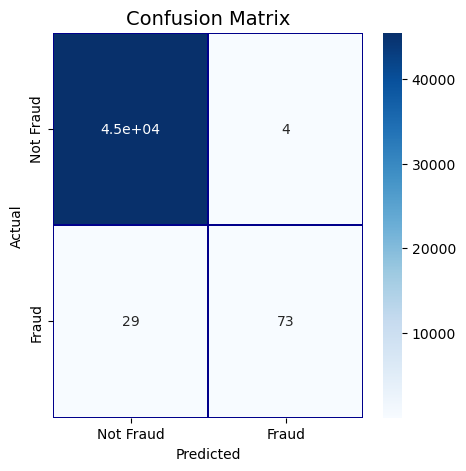

In [44]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [45]:
roc_auc_score(valid_df[target].values, preds)

0.8577991493075996

# XGBoost Classifier

In [46]:
# Parameters for training and validating datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [47]:
# Training the dataset using Xgboost classifier, note that the dataset is imbalance
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

C:\Users\HP\anaconda3\lib\site-packages\xgboost\core.py:568: FutureWarning:

Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.



[23:51:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.89296	valid-auc:0.85272
[50]	train-auc:0.93947	valid-auc:0.88200
[100]	train-auc:0.94415	valid-auc:0.89094
[150]	train-auc:0.97837	valid-auc:0.96362
[200]	train-auc:0.99002	valid-auc:0.98397
[250]	train-auc:0.99382	valid-auc:0.98592
[300]	train-auc:0.99567	valid-auc:0.98667
[332]	train-auc:0.99675	valid-auc:0.98558


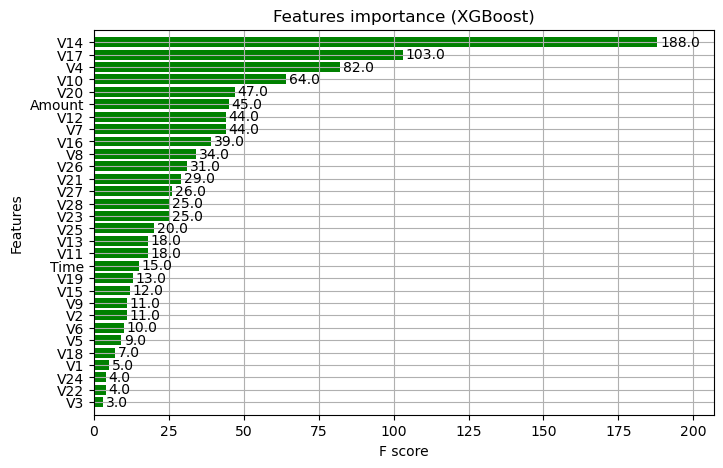

In [48]:
# Plotting the feature importance of all features under XGboost classifier
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [49]:
# Prediction
preds = model.predict(dtest)

In [50]:
roc_auc_score(test_df[target].values, preds)

0.9766700080897612

# LightBoost Classifier

In [51]:
# Parameters for training and validating datasets
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [52]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [53]:
evals_results = {}
# Training the dataset using lightboost classifier, note that the dataset is imbalance
model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)


C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089813 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864


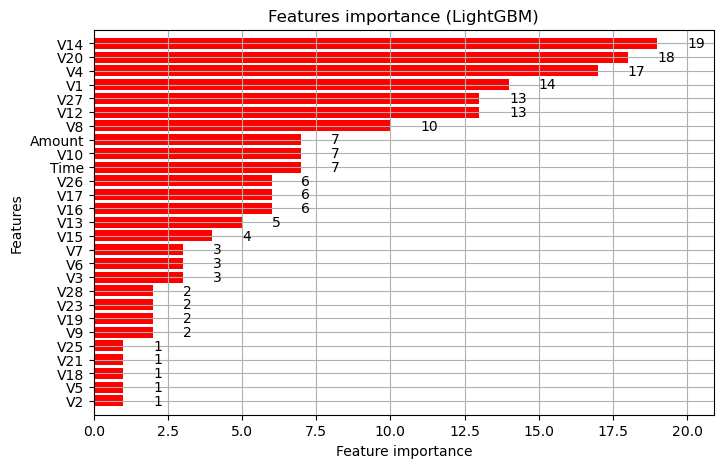

In [54]:
# Plotting the feature importance of all features under lightboost classifier
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [55]:
preds = model.predict(test_df[predictors])

In [56]:
roc_auc_score(test_df[target].values, preds)

0.9473337202349548

# Deep Learning

In [58]:
import tensorflow as tf
from tensorflow import keras

In [59]:
# Building a neural network with two hidden layers, and an input shape of 30. 
model_dl=keras.Sequential([
    keras.layers.Dense(30, input_shape=(30,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model_dl.compile(optimizer='adam',loss='binary_crossentropy',metrics=[keras.metrics.AUC(from_logits=True)])
# Training the dataset using deep neural network, note that the dataset is imbalance
model_dl.fit(train_df[predictors], train_df[target].values, epochs=10)

Epoch 1/10
5697/5697 [==============================] - 19s 3ms/step - loss: 1.1134 - auc: 0.5214
Epoch 2/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0294 - auc: 0.5613
Epoch 3/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0142 - auc: 0.5733
Epoch 4/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0132 - auc: 0.5161
Epoch 5/10
5697/5697 [==============================] - 15s 3ms/step - loss: 0.0192 - auc: 0.5017
Epoch 6/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0130 - auc: 0.5017
Epoch 7/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0123 - auc: 0.5017
Epoch 8/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0121 - auc: 0.5000
Epoch 9/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0129 - auc: 0.5017
Epoch 10/10
5697/5697 [==============================] - 16s 3ms/step - loss: 0.0126 - auc: 0.5017


In [60]:
preds = model_dl.predict(test_df[predictors])
roc_auc_score(test_df[target].values, preds)

1781/1781 [==============================] - 4s 2ms/step


0.4987425697302241

# Oversampling and Under-Sampling

In [61]:
train_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour'],
      dtype='object')

In [62]:
test_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour'],
      dtype='object')

In [63]:
data_df['Class'].value_counts()

#we can see that the class column is not balanced

0    284315
1       492
Name: Class, dtype: int64

# Undersampling

In [64]:
# Classifying each classes into count_class_0 and count_class_1
count_class_0,count_class_1=data_df['Class'].value_counts()

In [65]:
df_class_1=data_df[data_df['Class']==1]
df_class_0=data_df[data_df['Class']==0]

In [66]:
# Shape of class_0
df_class_0.shape

(284315, 32)

In [67]:
# shape of class_1
df_class_1.shape

(492, 32)

In [68]:
# Concatenating the two classes afte undersampling class_0. 
# Undersampling is reducing the majority class to the minority class
df_class_0_under=df_class_0.sample(count_class_1)
df_under=pd.concat([df_class_0_under,df_class_1], axis=0)
df_under.shape

(984, 32)

In [69]:
# Majority class has been undersampled to the minority class
df_under['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

From the above code, we can see that we have undersampled class 0 to the numbers of class 1. It tries to balance the majority class to the minority class

# Test-Train in Undersampling

In [70]:
train_df_under, test_df_under = train_test_split(df_under, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df_under, valid_df_under = train_test_split(train_df_under, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# RandomForest Classifier

In [71]:
# Training the dataset using randomforest classifier, note that the dataset is undersampled
clf_under = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [72]:
# Fitting of the datset on the training and testing dataset
clf_under.fit(train_df_under[predictors], train_df_under[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [73]:
# Predictions
preds_clf_under = clf_under.predict(valid_df_under[predictors])

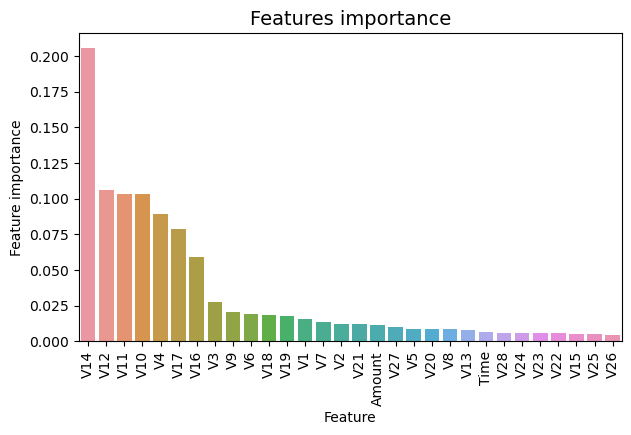

In [74]:
# Plotting the feature importance of all features under randomforest classifier
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_under.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   
#The most important features are V17, V12, V14, V10, V11, V16.

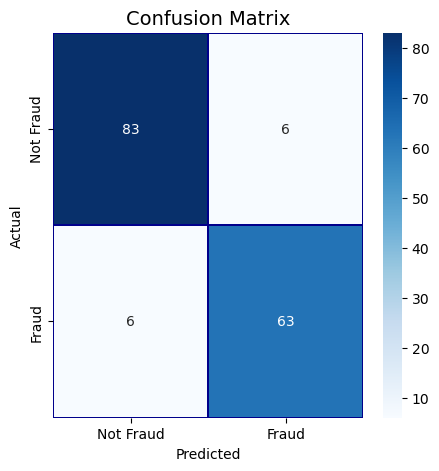

In [75]:
# confusion matrix
cm_under = pd.crosstab(valid_df_under[target].values, preds_clf_under, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm_under, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [76]:
roc_auc_score(valid_df_under[target].values, preds_clf_under)

0.9228138739618955

# AdaBoost Classifier

In [77]:
# Training the dataset using adaboost classifier, note that the dataset is undersampled
clf_ada_under = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [78]:
# Fitting of the datset on the training and testing dataset
clf_ada_under.fit(train_df_under[predictors], train_df_under[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [79]:
# Prediction
preds_ada_under = clf_ada_under.predict(valid_df_under[predictors])

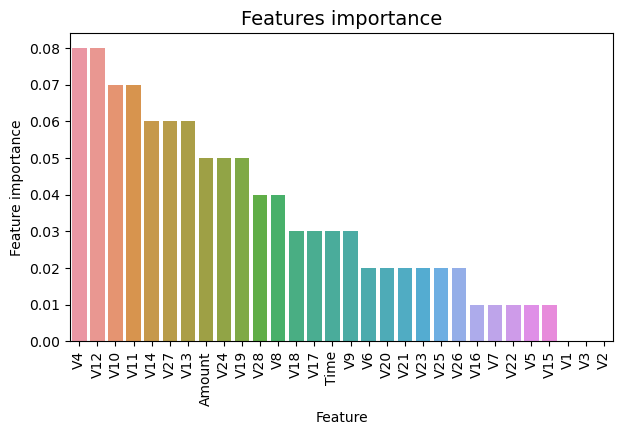

In [80]:
# Plotting the feature importance of all features under adaboost classifier
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_ada_under.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

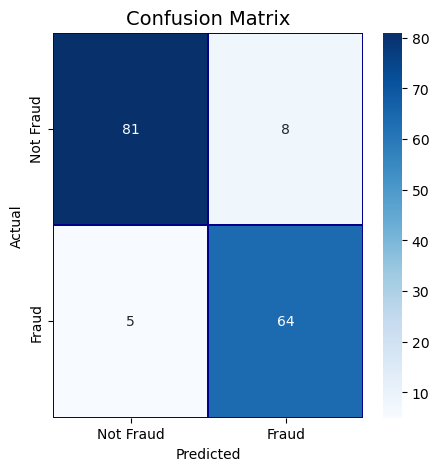

In [81]:
cm_ada_under = pd.crosstab(valid_df_under[target].values, preds_ada_under, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm_ada_under, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [82]:
roc_auc_score(valid_df_under[target].values, preds_ada_under)

0.91882429571731

# CatBoost Classifier

In [83]:
# Training the dataset using catboost classifier, note that the dataset is undersampled
clf_cat_under = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [84]:
# Fitting of the datset on the training and testing dataset
clf_cat_under.fit(train_df_under[predictors], train_df_under[target].values,verbose=True)

0:	total: 667ms	remaining: 5m 32s
50:	total: 33.7s	remaining: 4m 56s
100:	total: 1m 3s	remaining: 4m 11s
150:	total: 1m 36s	remaining: 3m 42s
200:	total: 2m 13s	remaining: 3m 18s
250:	total: 2m 43s	remaining: 2m 42s
300:	total: 3m 13s	remaining: 2m 7s
350:	total: 3m 47s	remaining: 1m 36s
400:	total: 4m 18s	remaining: 1m 3s
450:	total: 4m 48s	remaining: 31.3s
499:	total: 5m 19s	remaining: 0us


In [85]:
# Predictions
preds_cat_under = clf_cat_under.predict(valid_df_under[predictors])

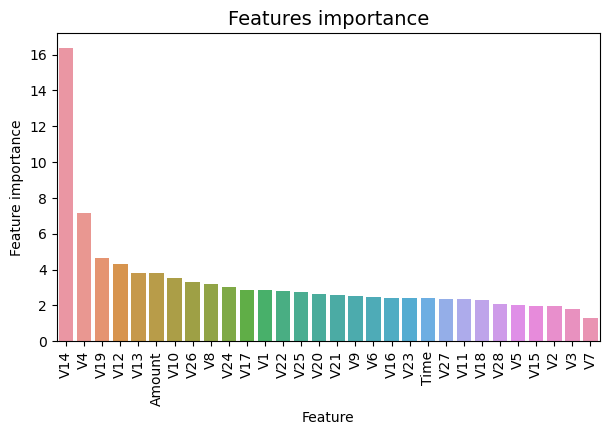

In [86]:
# Plotting the feature importance of all features under catboost classifier
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_cat_under.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

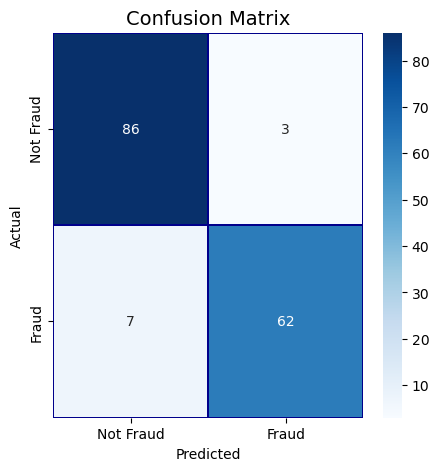

In [87]:
cm = pd.crosstab(valid_df_under[target].values, preds_cat_under, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [88]:
roc_auc_score(valid_df_under[target].values, preds_cat_under)

0.932421429734571

# XGBoost Classifier

In [89]:
# Prepare the train and valid datasets
dtrain_under = xgb.DMatrix(train_df_under[predictors], train_df_under[target].values)
dvalid_under = xgb.DMatrix(valid_df_under[predictors], valid_df_under[target].values)
dtest_under = xgb.DMatrix(test_df_under[predictors], test_df_under[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain_under, 'train'), (dvalid_under, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [90]:
# Training the undersampled dataset using xgboost
model = xgb.train(params, 
                dtrain_under, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[00:04:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.95715	valid-auc:0.92094
[50]	train-auc:0.99375	valid-auc:0.97468


C:\Users\HP\anaconda3\lib\site-packages\xgboost\core.py:568: FutureWarning:

Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.



[88]	train-auc:0.99734	valid-auc:0.97134


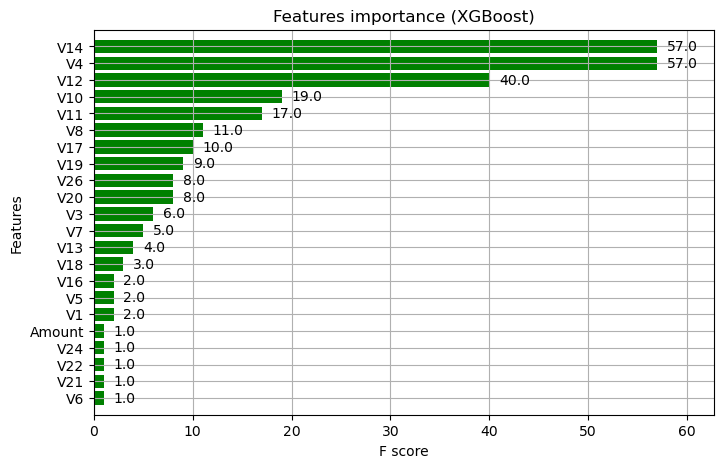

In [91]:
# Feature importance after traing the dataset using xgboost
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [92]:
preds_xgb_under = model.predict(dtest_under)

In [93]:
roc_auc_score(test_df_under[target].values, preds_xgb_under)

0.9680478251906823

# LightBoost Classifier

In [94]:
# Parameters for lightboost
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [95]:
# Defining training and valid dataset
dtrain_lgb_under = lgb.Dataset(train_df_under[predictors].values, 
                     label=train_df_under[target].values,
                     feature_name=predictors)

dvalid_lgb_under = lgb.Dataset(valid_df_under[predictors].values,
                     label=valid_df_under[target].values,
                     feature_name=predictors)

In [96]:
evals_results = {}
# Training the dataset using the defined parameters
model = lgb.train(params, 
                  dtrain_lgb_under, 
                  valid_sets=[dtrain_lgb_under, dvalid_lgb_under], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



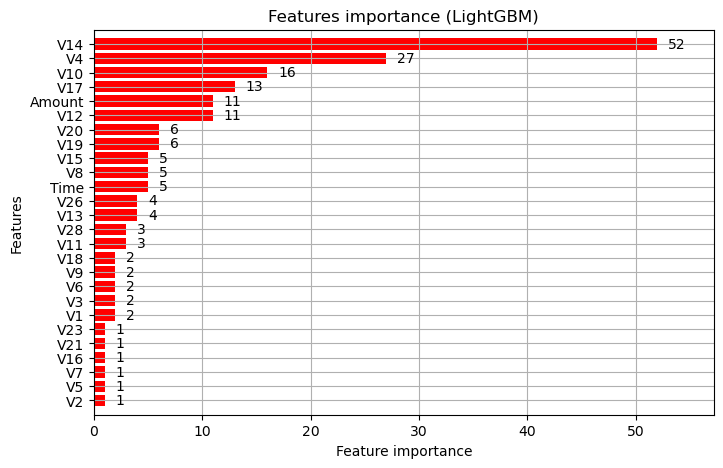

In [97]:
# Feature importance using lightboost
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [98]:
preds_lgb_under = model.predict(test_df_under[predictors])

In [99]:
roc_auc_score(test_df_under[target].values, preds_lgb_under)

0.9657802514945372

# Deep Learning

In [100]:
# Building a neural network with two hidden layers, and an input shape of 30.
model_dl_under=keras.Sequential([
    keras.layers.Dense(30, input_shape=(30,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model_dl_under.compile(optimizer='adam',loss='binary_crossentropy',metrics=[keras.metrics.AUC(from_logits=True)])
# Fitting the model on test and training dataset
model_dl_under.fit(train_df_under[predictors], train_df_under[target].values, epochs=10)

Epoch 1/10
20/20 [==============================] - 1s 5ms/step - loss: 1176.4199 - auc_1: 0.5000
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 524.8965 - auc_1: 0.5033
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 56.8569 - auc_1: 0.5433
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 20.8616 - auc_1: 0.5464
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 12.9136 - auc_1: 0.5458
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 4.6985 - auc_1: 0.6300
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 9.2369 - auc_1: 0.5572
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 11.6223 - auc_1: 0.5735
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 10.2560 - auc_1: 0.5740
Epoch 10/10
20/20 [==============================] - 0s 4ms/step - loss: 7.2671 - auc_1: 0.6094


In [101]:
preds_dl_under = model_dl_under.predict(test_df_under[predictors])
roc_auc_score(test_df_under[target].values, preds_dl_under)

7/7 [==============================] - 0s 3ms/step


0.6465677179962895

# Oversampling Technique

In [102]:
# The number of class_0 and class_1 
count_class_0,count_class_1

(284315, 492)

In [103]:
df_class_1=data_df[data_df['Class']==1]
df_class_0=data_df[data_df['Class']==0]

In [104]:
# Concatenating the oversampled minority class with class_0
df_class_1_over= df_class_1.sample(count_class_0, replace=True)
df_over=pd.concat([df_class_1_over,df_class_0],axis=0)
df_over.shape

(568630, 32)

In [105]:
df_over['Class'].value_counts()
# We can see that each class is adequately balanced

1    284315
0    284315
Name: Class, dtype: int64

# Train-Test Split

In [106]:
train_df_over, test_df_over = train_test_split(df_over, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df_over, valid_df_over = train_test_split(train_df_over, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# RandomForest Classifier

In [107]:
# Training the dataset using randomforest classifier, note that the dataset is oversampled
clf_over = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [108]:
# Fitting the dataset into train and test dataset
clf_over.fit(train_df_over[predictors], train_df_over[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [109]:
# Prediction
preds_clf_over = clf_over.predict(valid_df_over[predictors])

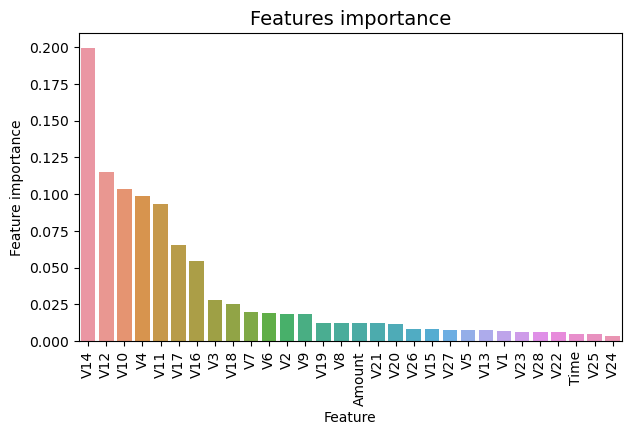

In [110]:
# Randomforest feature importance
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_over.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   
#The most important features are V17, V12, V14, V10, V11, V16.

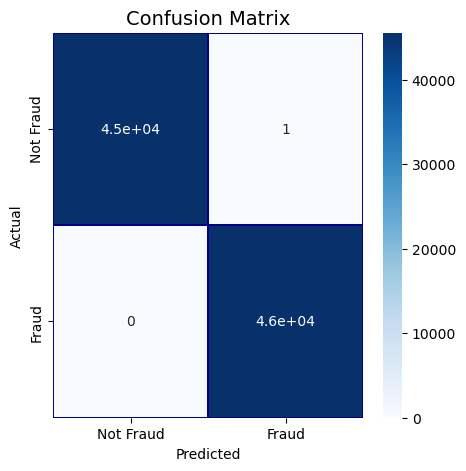

In [111]:
cm_under = pd.crosstab(valid_df_over[target].values, preds_clf_over, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm_under, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [112]:
roc_auc_score(valid_df_over[target].values, preds_clf_over)

0.9999889976895149

# AdaBoost Classifier

In [113]:
# Training the dataset using adaboost classifier, note that the dataset is oversampled
clf_ada_over = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)


In [114]:
# Fitting the dataset on train and test dataset
clf_ada_over.fit(train_df_over[predictors], train_df_over[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [115]:
# Prediction
preds_ada_over = clf_ada_over.predict(valid_df_over[predictors])

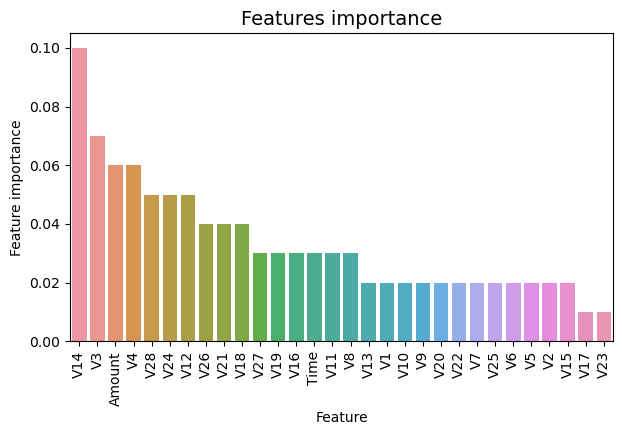

In [116]:
#Adaboost feature importance 
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_ada_over.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

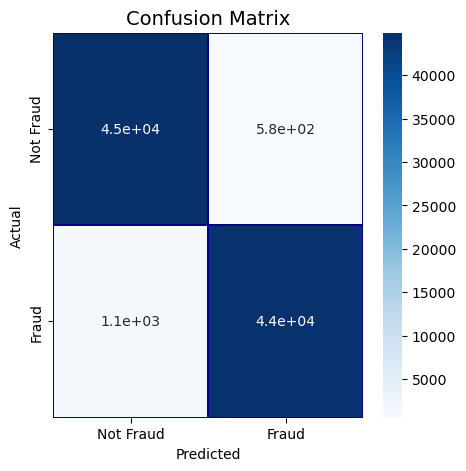

In [117]:
cm_ada_over = pd.crosstab(valid_df_over[target].values, preds_ada_over, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm_ada_over, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [118]:
roc_auc_score(valid_df_over[target].values, preds_ada_over)

0.9811012013374882

# CatBoost Classifier

In [119]:
# Training the dataset using catboost classifier, note that the dataset is oversampled
clf_cat_over = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [120]:
# Fitting the dataset on train and test dataset
clf_cat_over.fit(train_df_over[predictors], train_df_over[target].values,verbose=True)

0:	total: 1.13s	remaining: 9m 23s
50:	total: 1m 1s	remaining: 9m 5s
100:	total: 2m 1s	remaining: 7m 58s
150:	total: 2m 57s	remaining: 6m 50s
200:	total: 3m 53s	remaining: 5m 46s
250:	total: 4m 44s	remaining: 4m 42s
300:	total: 5m 41s	remaining: 3m 45s
350:	total: 6m 33s	remaining: 2m 46s
400:	total: 7m 27s	remaining: 1m 50s
450:	total: 8m 17s	remaining: 54.1s
499:	total: 9m 9s	remaining: 0us


In [121]:
# Prediction
preds_cat_over = clf_cat_over.predict(valid_df_over[predictors])

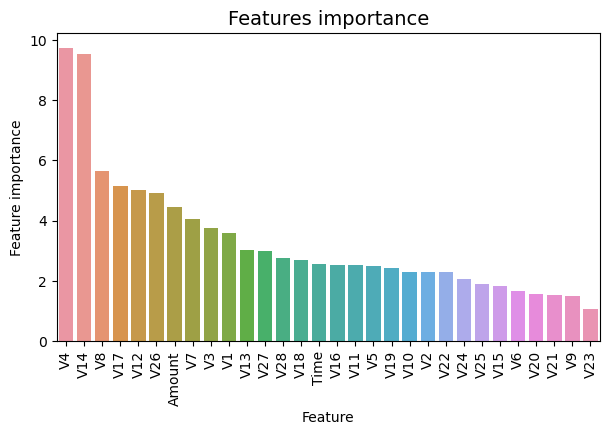

In [122]:
# Catboost feature importance
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_cat_over.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

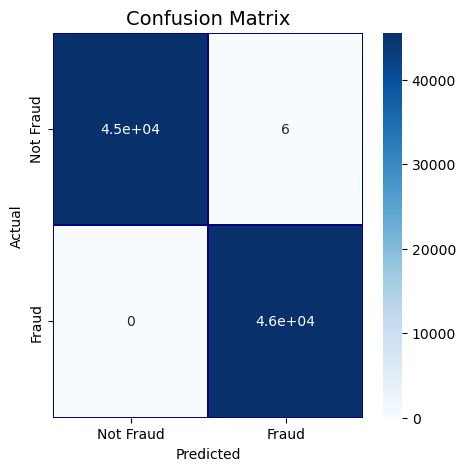

In [123]:
cm = pd.crosstab(valid_df_over[target].values, preds_cat_over, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [124]:
roc_auc_score(valid_df_over[target].values, preds_cat_over)

0.9999339861370887

# XGBoost Classifier

In [125]:
# Prepare the train and valid datasets
dtrain_over = xgb.DMatrix(train_df_over[predictors], train_df_over[target].values)
dvalid_over = xgb.DMatrix(valid_df_over[predictors], valid_df_over[target].values)
dtest_over = xgb.DMatrix(test_df_over[predictors], test_df_over[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain_over, 'train'), (dvalid_over, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [126]:
# Training the dataset using xgboost model
model = xgb.train(params, 
                dtrain_over, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)



C:\Users\HP\anaconda3\lib\site-packages\xgboost\core.py:568: FutureWarning:

Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.



[00:22:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.96014	valid-auc:0.96076
[50]	train-auc:0.98603	valid-auc:0.98618
[100]	train-auc:0.99186	valid-auc:0.99195
[150]	train-auc:0.99494	valid-auc:0.99497
[200]	train-auc:0.99663	valid-auc:0.99666
[250]	train-auc:0.99756	valid-auc:0.99762
[300]	train-auc:0.99824	valid-auc:0.99829
[350]	train-auc:0.99870	valid-auc:0.99878
[400]	train-auc:0.99902	valid-auc:0.99908
[450]	train-auc:0.99923	valid-auc:0.99929
[500]	train-auc:0.99939	valid-auc:0.99945
[550]	train-auc:0.99949	valid-auc:0.99956
[600]	train-auc:0.99958	valid-auc:0.99965
[650]	train-auc:0.99964	valid-auc:0.99971


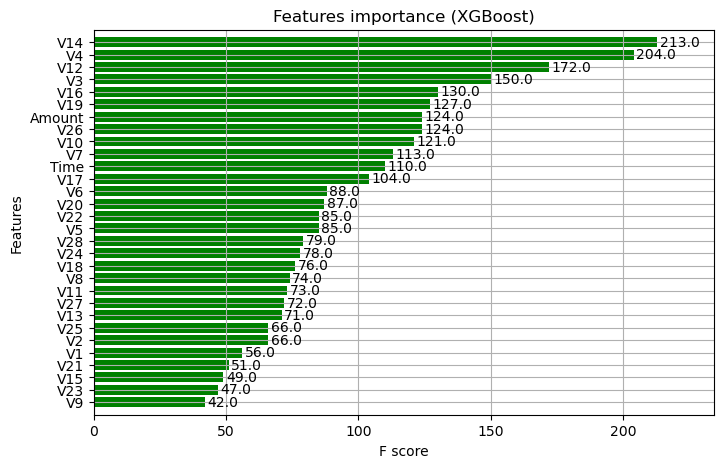

In [127]:
# Feature importance using xgboost model
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [128]:
preds_xgb_over = model.predict(dtest_over)

In [129]:
roc_auc_score(test_df_over[target].values, preds_xgb_over)

0.9998952959326072

# LightBoost Classifier

In [130]:
# defining parameters for model training
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [131]:
dtrain_lgb_over = lgb.Dataset(train_df_over[predictors].values, 
                     label=train_df_over[target].values,
                     feature_name=predictors)

dvalid_lgb_over = lgb.Dataset(valid_df_over[predictors].values,
                     label=valid_df_over[target].values,
                     feature_name=predictors)


In [132]:
evals_results = {}
# Model training 
model = lgb.train(params, 
                  dtrain_lgb_over, 
                  valid_sets=[dtrain_lgb_over, dvalid_lgb_over], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)



C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\Users\HP\anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107345 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.994169	valid's auc: 0.994286
[100]	train's auc: 0.997966	valid's auc: 0.998009
[150]	train's auc: 0.999146	valid's auc: 0.999229
[200]	train's auc: 0.999608	valid's auc: 0.999703
[250]	train's auc: 0.99971	valid's auc: 0.999806
[300]	train's auc: 0.999757	valid's auc: 0.999855
[350]	train's auc: 0.999801	valid's auc: 0.999886
[400]	train's auc: 0.999828	valid's auc: 0.999916
[450]	train's auc: 0.999847	valid's auc: 0.999927
[500]	train's auc: 0.999862	valid's auc: 0.999935
[550]	train's auc: 0.999899	valid's auc: 0.999952
[600]	train's auc: 0.999954	valid's auc: 0.999978
[650]	train's auc: 0.999961	valid's auc: 0.999984
[700]	train's auc: 0.999964	valid's auc: 0.999988
[750]	train's auc: 0.999968	valid's auc: 0.999991
[800]	train's auc: 0.9999

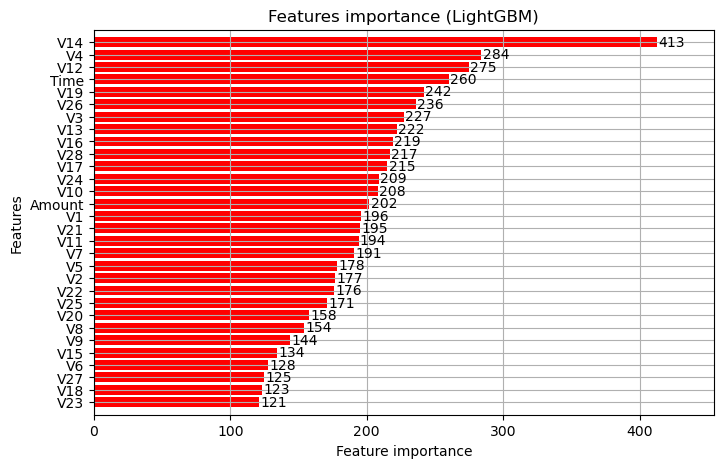

In [133]:
# Feature importance using lightboost
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()


In [134]:
preds_lgb_over = model.predict(test_df_over[predictors])

In [135]:
roc_auc_score(test_df_over[target].values, preds_lgb_over)

0.9999934604415743

# Deep Learning

In [136]:

# Building a neural network with two hidden layers, and an input shape of 30.
model_dl_over=keras.Sequential([
    keras.layers.Dense(30, input_shape=(30,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model_dl_over.compile(optimizer='adam',loss='binary_crossentropy',metrics=[keras.metrics.AUC(from_logits=True)])
# Fitting the model on test and training dataset
model_dl_over.fit(train_df_over[predictors], train_df_over[target].values, epochs=10)

Epoch 1/10
11373/11373 [==============================] - 35s 3ms/step - loss: 15.3929 - auc_2: 0.7834
Epoch 2/10
11373/11373 [==============================] - 31s 3ms/step - loss: 1.7114 - auc_2: 0.9011
Epoch 3/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.6800 - auc_2: 0.5465
Epoch 4/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.7198 - auc_2: 0.5031
Epoch 5/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.6926 - auc_2: 0.5029
Epoch 6/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.7027 - auc_2: 0.5036
Epoch 7/10
11373/11373 [==============================] - 31s 3ms/step - loss: 0.6942 - auc_2: 0.5017
Epoch 8/10
11373/11373 [==============================] - 34s 3ms/step - loss: 0.6970 - auc_2: 0.5027
Epoch 9/10
11373/11373 [==============================] - 34s 3ms/step - loss: 0.6989 - auc_2: 0.5100
Epoch 10/10
11373/11373 [==============================] - 32s 3ms/step - loss: 0

In [137]:
preds_dl_over = model_dl_over.predict(test_df_over[predictors])

3554/3554 [==============================] - 7s 2ms/step


In [138]:
preds_dl_over = model_dl.predict(test_df_over[predictors])
roc_auc_score(test_df_over[target].values, preds_dl_over)

3554/3554 [==============================] - 7s 2ms/step


0.5017512524585802